<a href="https://colab.research.google.com/github/yecatstevir/teambrainiac/blob/main/source/SVM_Group_Child_Whole_Brain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Whole Brain Support Vector Machine Training
- Go to 'Runtime' in Colab browser bar, select 'Change Runtime Type', select 'High-RAM' from 'Runtime Shape'. 
- load local pickle file containing all masked, normalized Whole Brain subject data in numpy matrix format
- SVM training per group (subject ids of '100XX-XXXXX' for Adolescent (child) and '300XX-XXXXX' for Young Adult)

### Mount Google Drive and clone repository
- open to source directory

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')#, force_remount = True)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# Clone the entire repo.
!git clone -l -s https://github.com/yecatstevir/teambrainiac.git
# Change directory into cloned repo
%cd teambrainiac/source
!ls


fatal: destination path 'teambrainiac' already exists and is not an empty directory.
/content/teambrainiac/source
Access_Load_Data.ipynb		  models
All_subject_masked_labeled.ipynb  path_config.py
cross_validation.py		  percent_signal_change.ipynb
data				  process.py
Explore_data.ipynb		  __pycache__
explore.py			  SVM_Group_Child_Whole_Brain.ipynb
Images				  SVM_Group_YA_Whole_brain.ipynb
__init__.py			  utils.py
Masking.ipynb			  Visualize_Data.ipynb
Mat_to_Numpy.ipynb


### Load path_config.py 
- we are already in source so we can just load this file without chanding directory

In [3]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving path_config.py to path_config (1).py
User uploaded file "path_config.py" with length 228 bytes


#### Import libraries


In [ ]:
# Import libraries
!pip install boto3 nilearn
import pickle
from utils import *
from process import *
from cross_validation import *
from sklearn.svm import SVC
import numpy as np
from sklearn.metrics import accuracy_score
import pandas as pd

### Load Data from AWS and create Train/Val/Test splits

In [5]:
%%time
pkl_file = "whole_brain_all_norm_2d.pkl" # normalized
#pkl_file = 'all_data_dictionary.pkl' #Unnormalized
bool_mat = False
data = access_load_data(pkl_file, bool_mat)

CPU times: user 1min 7s, sys: 1min 30s, total: 2min 37s
Wall time: 2min 9s


In [6]:
#open path dictionary file to get subject ids
path = "data/data_path_dictionary.pkl"
data_path_dict = open_pickle(path)
subject_ids = data_path_dict['subject_ID']

# Split dataset into young children and older children/young adults
child = subject_ids[:33]
teen_plus = subject_ids[33:]
print("Number of subjects for child and teens", len(child), len(teen_plus))

Number of subjects for child and teens 33 19


#Time Series Cross Validation
## Organize Data Child for Cross Validation
If we are performing cross validation, we need to get the data without splitting first

In [7]:
%%time 

#Function Calls
group_sub_ids = child # child, teen_plus (Adolescent or Young Adult, respectively)
runs_train = 1 # Grab run 2 (0 indexing)
runs_test = 2 # Grab run 3 (0 indexing)
norm = "RUNS" #"RUNS", "SUBJECT", False 


X, y = data_for_cv(data, group_sub_ids, runs_train, runs_test, norm)

Normalizing Each based on RUNS...
X train data shape after concantenation (2772, 237979)
y train data shape after concantenation (2772,)
X test data shape after concantenation (2772, 237979)
y test data shape after concantenation (2772,)
Final X data shape to feed into Time Series Cross Validation (5544, 237979)
Final y data shape to feed into Time Series Cross Validation (5544,)
CPU times: user 22.6 s, sys: 12.2 s, total: 34.8 s
Wall time: 34.6 s


### Run the Time Series Cross Validation

In [8]:
max_train = 2772
test_size = None
splits = 5

time_series_cv(X, y, max_train, test_size, splits)

0it [00:00, ?it/s]

Fitting Classifier for iteration number 1
Predicting...


1it [09:28, 568.74s/it]

Cross Validation Split 1 Accuracy score: 0.6796536796536796
Fitting Classifier for iteration number 2
Predicting...


2it [27:27, 869.02s/it]

Cross Validation Split 2 Accuracy score: 0.7543290043290043
Fitting Classifier for iteration number 3
Predicting...


3it [50:21, 1099.55s/it]

Cross Validation Split 3 Accuracy score: 0.7316017316017316
Fitting Classifier for iteration number 4
Predicting...


4it [1:12:41, 1194.31s/it]

Cross Validation Split 4 Accuracy score: 0.711038961038961
Fitting Classifier for iteration number 5
Predicting...


5it [1:35:29, 1145.87s/it]

Cross Validation Split 5 Accuracy score: 0.7662337662337663
Mean Accuracy: 0.7285714285714286


# Process Data for SVM
- Split data into Train, Val, Test sets
- Scale
- Specify which runs to include

In [9]:
# get train, test val data
train_ids = child[:28]
val_ids = child[28:34]
test_ids = child

group_sub_ids = (train_ids, val_ids, test_ids)
runs_train = 1 # grabs the second run
runs_test = 2 # grabds the third run
norm = "RUNS" # Normalizes per run

print("Number of child training examples: ", len(train_ids))
print("Number of child validation examples: ", len(val_ids))
print("Number of child testing examples: ", len(test_ids))
print(len(child))

# Get all the data we need for SVM
X, y, X_v, y_v, X_t, y_t = transform_data(data, group_sub_ids, runs_train, runs_val, runs_test, norm)

Number of child training examples:  28
Number of child validation examples:  5
Number of child testing examples:  33
33
Normalizing Each based on RUNS...
X train data shape after concantenation (2352, 237979)
y train data shape after concantenation (2352,)
X test data shape after concantenation (2772, 237979)
y test data shape after concantenation (2772,)
X val data shape after concantenation (420, 237979)
y val data shape after concantenation (420,)
Final X Train data shape (2352, 237979)
Final y Train data shape  (2352,)
Final X Val data shape (420, 237979)
Final y Val data shape  (420,)
Final X Test data shape (2772, 237979)
Final y Test data shape  (2772,)


# SVM Model Prediction for Children

#### SKlearn model training on Group data for Child

In [10]:
%%time
#kernel = 'sigmoid'
model_name = f"group_child_svm_norm_runs_{runs_train}_{runs_test}_v2"
clf = SVC(C = 5.0 , class_weight= 'balanced', max_iter = 1000, random_state = 42)
clf.fit(X, y)
f = open("models/%s.pkl"%model_name,"wb")
pickle.dump(clf, f)
f.close()

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


CPU times: user 27min 12s, sys: 6min 13s, total: 33min 26s
Wall time: 4min 41s


In [11]:
%%time
yval_pred = clf.predict(X_v)
# Model Accuracy
print("Accuracy:", accuracy_score(y_v, yval_pred))

Accuracy: 0.7547619047619047
CPU times: user 19min 49s, sys: 48min 31s, total: 1h 8min 20s
Wall time: 8min 38s


#### Predict on held out test data

In [12]:
%%time
ytest_pred = clf.predict(X_t)

# Model Accuracy
print("Accuracy:", accuracy_score(y_t, ytest_pred))

Accuracy: 0.7186147186147186
CPU times: user 2h 11min 4s, sys: 5h 18min 27s, total: 7h 29min 32s
Wall time: 56min 51s


#### Check Support Vectors

In [13]:
print("number of support vectors:", len(clf.support_))
clf.support_ #Indices of support vectors

number of support vectors: 1737


array([  14,   15,   16, ..., 2334, 2337, 2344], dtype=int32)

In [14]:
clf.dual_coef_

array([[-0.98512847, -1.07696165, -0.68635341, ...,  1.04505652,
         0.59311151,  0.47750976]])

In [15]:
clf.dual_coef_.shape

(1, 1737)

In [16]:
clf.support_.shape


(1737,)

#### Create Alphas

In [17]:
alphas = np.zeros((2352)) #create empty array
alphas.shape

(2352,)

In [18]:
alphas[clf.support_] = clf.dual_coef_ #Load the weights corresponding to where support vectors are 
alphas.shape

(2352,)

In [19]:
alphas = alphas.reshape(1,-1)
alphas.shape

(1, 2352)

#### Create Beta Map

In [20]:
mask_data_path = data_path_dict['mask_data'][0]
mask_type_dict = access_load_data(mask_data_path,True)
np_array_mask = mask_type_dict['mask']
print("mask shape:", np_array_mask.shape)

indices_mask = np.where(np_array_mask==1) # gets the indices where the mask is 1, the brain region for x, y, z planes
indices_mask

mask shape: (79, 95, 79)


(array([ 3,  3,  3, ..., 75, 75, 75]),
 array([36, 36, 36, ..., 47, 47, 47]),
 array([33, 34, 35, ..., 28, 29, 30]))

In [21]:
bmap = np.dot(alphas, X) # create Beta Map
bmap.shape

(1, 237979)

In [22]:
bmap2 = np.zeros((79,95,79))
bmap2[indices_mask] = bmap

### Threshold map

In [23]:
from IPython.core.display import HTML, Markdown, display

import numpy.random as npr
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.formula.api as smf

import ipywidgets as widgets

import requests
import zipfile
import os
import nibabel
from scipy.stats import gamma

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
"""
*** RESOURCE CODE BELOW FROM https://cims.nyu.edu/~brenden/courses/labincp/labs/Lab3/Lab-MRI.html
# use some numpy magic to get an array that is nan everywhere that the correlation value is less than .2

# first make a copy of the correlation values
r_thresholded = r_values_as_slice.copy()

# now set any values less than .2 to be equal to nan
r_thresh = .2
r_thresholded[r_thresholded < r_thresh] = np.nan

# Ok now lets visualize all the maps
fig, ax = plt.subplots(1,3,figsize=(18, 6))

# Create the plots
ax[0].imshow(functional_data[:,:,36,10], cmap='gray')
ax[0].set_title('brain slice', fontsize=25)
ax[0].set_xticks([])
ax[0].set_yticks([])


ax[1].imshow(r_values_as_slice,  cmap='afmhot')
ax[1].set_title('un-thresholded map', fontsize=25)
ax[1].set_xticks([])
ax[1].set_yticks([])


ax[2].imshow(functional_data[:,:,36,10], cmap='gray')
ax[2].imshow(r_thresholded, cmap='afmhot')
ax[2].set_title('thresholded map (r > ' + str(r_thresh) + ')', fontsize=25)
ax[2].set_yticks([])
ax[2].set_xticks([])
ax[2].set_yticks([])"""

IndexError: ignored

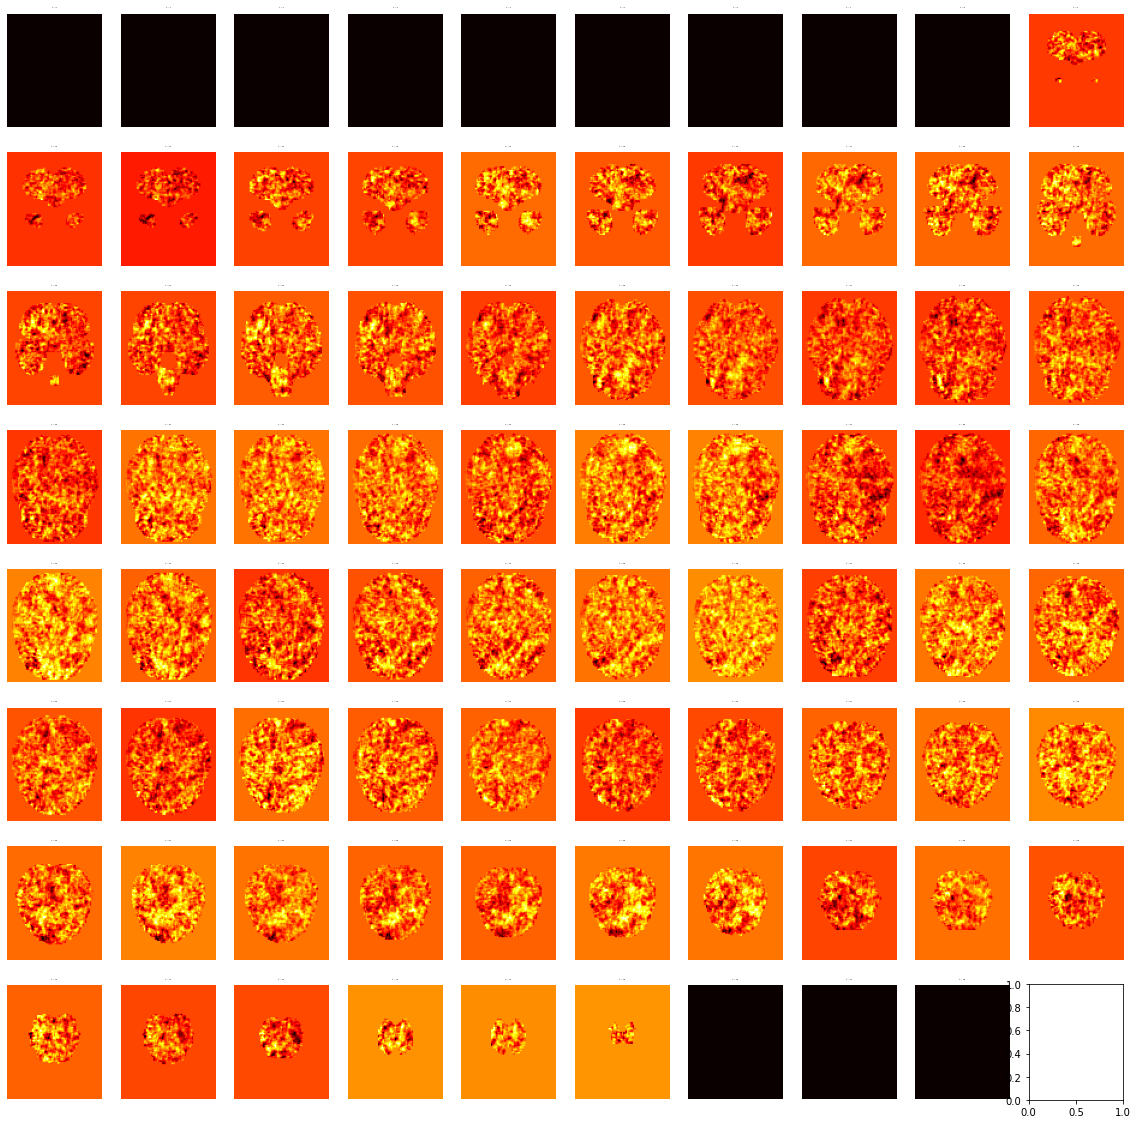

In [24]:
from matplotlib import patches
import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=10, nrows=8, figsize=(20, 20))  # 20 timepoints
# Loop over the first 20 volumes/timepoints
for t, ax in enumerate(axes.flatten()):    
    ax.imshow(bmap2[:, :, t].T, cmap='hot')#, origin='lower')  # index with t!
    rect = patches.Rectangle((38, 20), 2, 2, linewidth=2, edgecolor='r', facecolor='black')
    #ax.add_patch(rect)
    ax.axis('off')
    ax.set_title('t = %i' % t, fontsize=2)
fig.set_facecolor("gray")
fig.tight_layout()

In [25]:
## Cross Validation accuracy scores recorded

dictionary = {"Cross Validation Adolescent Train run 2/Test run 3": ["1","2","3","4","5","Average"], 
              "Unnormalized": [.50, .51, .50, .50, .50, .50],
              "PSC per run": [.53, .63, .50, .50, .59, .55 ], 
              "PSC + Z Norm per Subject": [.63, .72, .62, .58, .52, .61], 
              "PSC + Z Norm per Run": [.68, .75, .73, .71, .77, .73], 
              "Z Norm per Run (No PSC)": [.62, .71, .72, .65, .63, .67]
              }

df = pd.DataFrame(dictionary)
df.set_index("Cross Validation Adolescent Train run 2/Test run 3", inplace = True)
df

,Unnormalized,PSC per run,PSC + Z Norm per Subject,PSC + Z Norm per Run,Z Norm per Run (No PSC)
Cross Validation Adolescent Train run 2/Test run 3,,,,,
1,0.50,0.53,0.63,0.68,0.62
2,0.51,0.63,0.72,0.75,0.71
3,0.50,0.50,0.62,0.73,0.72
4,0.50,0.50,0.58,0.71,0.65
5,0.50,0.59,0.52,0.77,0.63
Average,0.50,0.55,0.61,0.73,0.67
